<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/2020/bow_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP Sac de mot

L'objectif de ce tp est de coder une approche sac de mots : c'est ce qu'on faisait de mieux **avant** le deep learning.


On va réutiliser MNIST que vous connaissez désormais.


## Création d'un dictionnaire

On va extraire un ensemble dense de patch dans des images MNIST et appliquer K moyenne dessus, cela nous donnera un dictionnaire de patches !

D'abord récupérons MNIST (avec torchvision -- juste par faciliter mais ce n'est pas pertinent).

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)




torch.Size([64, 1, 32, 32])


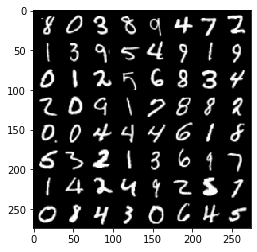

In [1]:
import torch
import torchvision
transform_mnist = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor()
])
mnisttrain = torchvision.datasets.MNIST("./mnist",train=True, transform=transform_mnist, download=True)
trainloader = torch.utils.data.DataLoader(mnisttrain, batch_size=64, shuffle=True, num_workers=2)
mnisttest = torchvision.datasets.MNIST("./mnist",train=False, transform=transform_mnist, download=True)
testloader = torch.utils.data.DataLoader(mnisttest, batch_size=64, shuffle=True, num_workers=2)

import matplotlib.pyplot as plt
import numpy as np
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

sample = next(iter(trainloader))[0]
show(torchvision.utils.make_grid(sample))
print(sample.shape)  ## 64 c'est le batch
                        ## 1 c'est du gris -- sinon ce serait 3 pour du RGB
                        ## 32x32 c'est pour la taille de l'image (petite ici)

**Q1** (moyen) : écrire une fonction qui extrait des patch 8x8 dans une image, les transforme en vecteur (flatten) et les mets dans une liste donnée en argument

In [2]:
def extraitpatch2D(allpatch,inputs):
  row = np.random.randint(0,32-8,size=10)
  col = np.random.randint(0,32-8,size=10)
  for i in range(row.shape[0]):
    allpatch.append(inputs[row[i]:row[i]+8,col[i]:col[i]+8].copy().flatten())

def extraitpatchinbatch(allpatch,inputs):
  for i in range(inputs.shape[0]):
      extraitpatch2D(allpatch,inputs[i][0].cpu().numpy())

**ATTENTION :** en fait c'est vraiment consommateur de ressource d'extraire autant de patches...

On vous fourniera une version qui tire au hasard des patchs à extraire (et qui repasse en numpy).

**Q2 (facile)** : utiliser la fonction show64patches pour visualiser 64 patchs tirés au hasard et/ou les patchs extraits d'une image unique. Chacun apporte une information "faible" mais dans leur ensemble, on espère qu'ils encodent l'image.

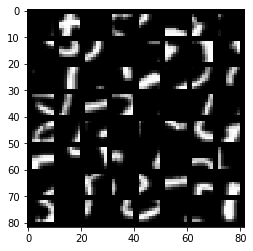

In [20]:
import random

def show64patch(patches):
  patches = [torch.Tensor(patches[i]) for i in range(64)]
  patches = [patch.view(8,8) for patch in patches]
  patches = [patch.unsqueeze(0) for patch in patches]
  patches = torch.stack(patches)
  show(torchvision.utils.make_grid(patches))

tmp = []
extraitpatchinbatch(tmp,sample)
random.shuffle(tmp)
show64patch(tmp)

**Q3 (facile)** Parcourer le dataset de train pour extraire "l'ensemble" des patchs de l'ensemble des images (normalement on utilise train **ET** test mais bon)

In [4]:
allpatch = []
for inputs,targets in trainloader:
  extraitpatchinbatch(allpatch,inputs)

**Q4 (moyen)** : Appliquer sklearn.cluster.KMeans pour créer un dictionnaire de 512 clusters

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


c'est normal si ça prend 10 mins !


In [5]:
from sklearn.cluster import KMeans

print(len(allpatch)) ## on a un gros problème Kmeans !! 
                     ## dimension des vecteurs 64, 
                     ## K = 512
                     ## N = 600000

kmeans = KMeans(n_clusters=512,max_iter=30,n_init=1).fit(allpatch)

600000


**Q5 (facile)** : avez vous utiliser les labels jusqu'à maintenant ??

Non pour l'instant on utilise que de la données !

In [ ]:
del allpatch

## Encodage

L'objectif maintenant est d'utiliser le dictionnaire pour créer une fonction qui prend une image en entrée et qui produit un histogramme H avec h_i qui correspond au nombre de fois qu'on a vu un patch qui se rattache au groupe "i" du dictionnaire !

cette fois on extraira tous les patchs -- vu que de toute façon on va juste en conserver leur index


In [9]:
print(kmeans.cluster_centers_.shape)

def extractallpatch(allpatch,image):
  for row in range(image.shape[0]-8):
    for col in range(image.shape[1]-8):
        allpatch.append(image[row:row+8,col:col+8].copy().flatten())

def extraitallpatchinbatch(allpatch,inputs):
  for i in range(inputs.shape[0]):
      extractallpatch(allpatch,inputs[i][0].cpu().numpy())

(512, 64)


**Q6 (facile)** : écrivez une fonction qui prend une liste contenant des entiers de 0 à 512 et qui retourne un histogramme de taille 512 avec h[i] le nombre de i dans la liste

In [21]:
def histogramme(intlist):
  out=np.zeros(512,dtype=int)
  for i in intlist:
    out[i]+=1
  return out

**Q7 facile :** écrire une fonction qui trie les indices d'un tableau en fonction des valeurs associées

In [22]:
def sortindex(histo):
  tmp = [(histo[i],i) for i in range(len(histo))]
  tmp = sorted(tmp)
  return [tmp[i][1] for i in range(len(histo))]


les patchs les plus commun sont probablement justes tout noir ou tout blanc, ils contiennent peu d'information...
d'un autre coté, si un groupe contient 0 patch il n'est pas intéressant non plus

Le code suivant récupère 3 indices contenant au moins 64 éléments...

In [32]:
def get3index(histo):
  tmp = [(histo[i],i) for i in range(len(histo))]
  tmp = sorted(tmp)
  i = 0
  while tmp[i][0]<64:
    i+=1
  return tmp[i][1],tmp[i+4][1],tmp[i+8][1]

**Q8 (moyen)** : visualiser des patchs d'un même centroide (disons correspondant à 3 centres comme ci dessus)

*regarder l'exemple donnée dans la doc de scikit -- il vous permet de voir comment avoir le label associé à un patch*

*ATTENTION 1 seul show par case de notebook*

le résultat des kmeans vous parait il pertinent ?



34 443 47


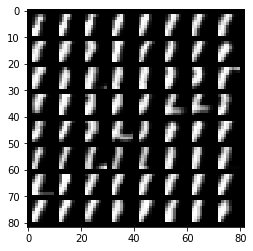

In [33]:

sample = next(iter(trainloader))[0]
tmp = []
extraitallpatchinbatch(tmp,sample)
labelsK = kmeans.predict(tmp)
hist = histogramme(labelsK)
a,b,c = get3index(hist)
print(a,b,c)

patchwithcenterA = [tmp[i] for i in range(len(tmp)) if labelsK[i]==a]
show64patch(patchwithcenterA)

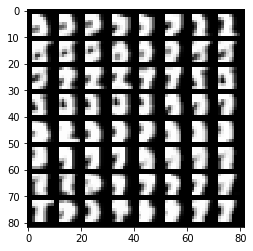

In [34]:

patchwithcenterB = [tmp[i] for i in range(len(tmp)) if labelsK[i]==b]
show64patch(patchwithcenterB)


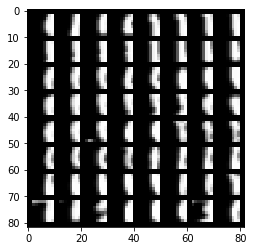

In [35]:

patchwithcenterC = [tmp[i] for i in range(len(tmp)) if labelsK[i]==c]
show64patch(patchwithcenterC)

**Q9 (moyen)** : écrire une fonction qui prend 1 image et produit l'histogramme associé

In [37]:
def encodeimage(image):
  tmp=[]
  extractallpatch(tmp,image)
  labelsK = kmeans.predict(tmp)
  return histogramme(labelsK)

def encodeimagebatch(inputs):
  tmp = []
  for i in range(inputs.shape[0]):
      tmp.append(encodeimage(inputs[i][0].cpu().numpy()))
  return tmp

## Classification

**Q BONUS** : parcourir l'ensemble du dataset de train, produire et stocker l'ensemble des histogrammes, puis apprendre un MLP (2 couches) ou arbre ou SVM sur ces histogrammes -> utiliser plutôt des classifiers scikit learn 

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

https://scikit-learn.org/stable/modules/tree.html#classification

https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification


Puis utiliser ce classifier sur les données de test -- (qu'il convient d'encoder au préalable)

In [39]:
print("encode and store train")
X,Y = [],[]
for x,y in trainloader:
  X+=encodeimagebatch(x)
  Y.append(y.cpu().numpy())
X = np.stack(X)
Y = np.concat(Y)

print("learn classifier")
from sklearn.svm import LinearSVC
clf = LinearSVC().fit(X, y)
del X
del Y

print("test")
goodclassif = 0
size=0
for x,y in testloader: 
  x = encodeimagebatch(x)
  y = y.cpu().numpy()
  pred = clf.predict(x)
  pred = np.asarray(pred)
  goodclassif+=np.sum((pred==y).astype(int))
  size+=y.shape[0]

print("accuracy = ",goodclassif/size*100)

encode and store train


KeyboardInterrupt: ignored